In [1]:
import json
import pandas as pd
import altair as alt
from utils import percentage_change
from datetime import datetime, timedelta

In [2]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
SAVE_CHARTS = True

Read in the sales data

In [4]:
df = pd.read_csv("./_data/sales.csv")

Parse the dates

In [5]:
df.date = pd.to_datetime(df.date)

Filter down to our buildings and areas we want to study

In [6]:
pwest = df[df.building_name == 'Promenade West']

In [7]:
bunker_hill = df[df.region == 'Bunker Hill']

What are the most recent sales at Promenade West?

In [8]:
pwest.sort_values("date", ascending=False)[[
    'building_name',
    'date',
    'unit',
    'price',
    'square_feet',
    'price_per_square_foot'
]].head(5)

,building_name,date,unit,price,square_feet,price_per_square_foot
2026,Promenade West,2018-11-26,412,580000.0,1348.0,430.267062
2027,Promenade West,2018-07-03,308,620000.0,1323.0,468.631897
2028,Promenade West,2018-06-12,527,600000.0,1323.0,453.514739
2029,Promenade West,2018-04-11,706,598000.0,1348.0,443.620178
2030,Promenade West,2018-02-01,409,590000.0,1323.0,445.956160


Write out its sales to use elsewhere.

In [9]:
pwest.to_csv("./_data/pwest_sales.csv", index=False)

Let's calculate some statistics

In [10]:
def year_over_year_comparison(df):
    this_year = df[df.year == datetime.now().year]
    last_year = df[df.year == datetime.now().year - 1]
    stats = {
        'this_year': {
            'count': len(this_year),
            'median_price': this_year.price.median(),
            'median_price_per_sqft': this_year.price_per_square_foot.median(),
        },
        'last_year': {
            'count': len(last_year),
            'median_price': last_year.price.median(),
            'median_price_per_sqft': last_year.price_per_square_foot.median(),
        },
        'all_time': {
            'median_sqft': df.square_feet.median()
        }
    }
    stats.update({
        'change': {
            'price': percentage_change(stats['last_year']['median_price'], stats['this_year']['median_price']), 
            'median_price_per_sqft': percentage_change(stats['last_year']['median_price_per_sqft'], stats['this_year']['median_price_per_sqft']), 
        }
    })
    return stats

Analyze Promenade West and the areas we care about using this tool.

In [11]:
pwest_yoy = year_over_year_comparison(pwest)
bunkerhill_yoy = year_over_year_comparison(bunker_hill)
dtla_yoy = year_over_year_comparison(df)

Write out the results

In [12]:
json.dump(pwest_yoy, open("./_data/pwest.json", "w"), indent=4)
json.dump(bunkerhill_yoy, open("./_data/bunkerhill.json", "w"), indent=4)
json.dump(dtla_yoy, open("./_data/dtla.json", "w"), indent=4)

### The pace of sales

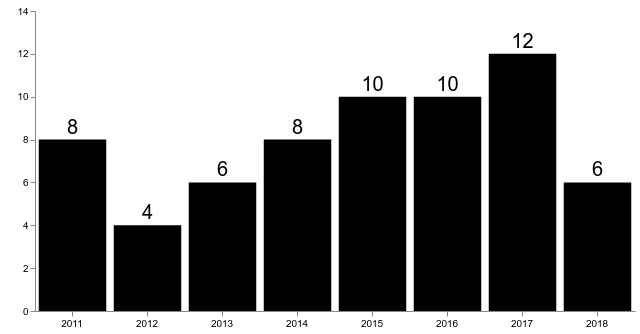

In [13]:
bars = alt.Chart(pwest).mark_bar(color="black").encode(
    x=alt.X("date:O", timeUnit="year", axis=alt.Axis(labelAngle=0, title="")),
    y=alt.Y("count()", scale=alt.Scale(domain=(0, 14)), axis=alt.Axis(title="", grid=False))
)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-12,
    size=20
).encode(text='count()')

chart = (bars + text).configure_view(
    strokeOpacity=0
).properties(width=600)

if SAVE_CHARTS:
    chart.save('assets/sales-by-year.svg')

chart

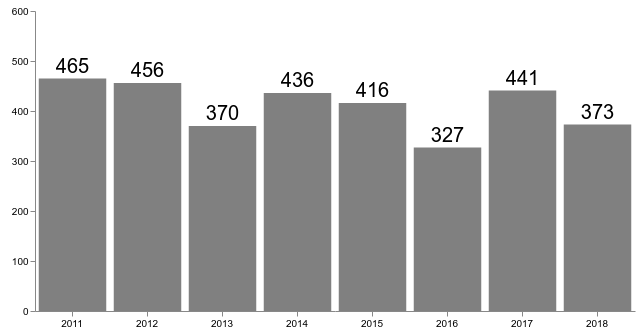

In [14]:
bars = alt.Chart(df).mark_bar(color="gray").encode(
    x=alt.X("date:O", timeUnit="year", axis=alt.Axis(labelAngle=0, title="")),
    y=alt.Y("count()", scale=alt.Scale(domain=(0, 600)), axis=alt.Axis(title="", grid=False))
)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-12,
    size=20
).encode(text='count()')

chart = (bars + text).configure_view(
    strokeOpacity=0
).properties(width=600)

if SAVE_CHARTS:
    chart.save('assets/dtla-sales-by-year.svg')

chart

### Prices by date

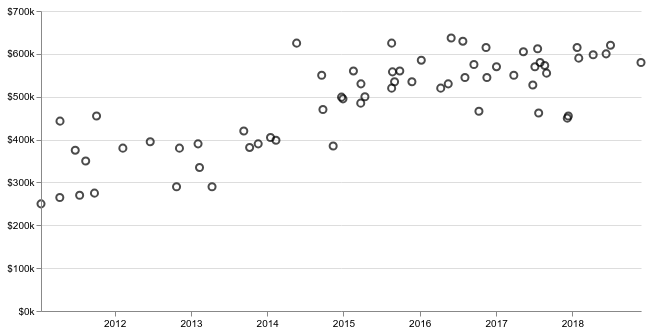

In [15]:
chart = alt.Chart(pwest).mark_point(size=50, color="black").encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s"),
        scale=alt.Scale(domain=[0, 700000])
    ),
    tooltip=["unit", "price", "square_feet", "price_per_square_foot"]
).configure_view(
    strokeOpacity=0
).properties(width=600)


if SAVE_CHARTS:
    chart.save('assets/price-by-date.svg')

chart

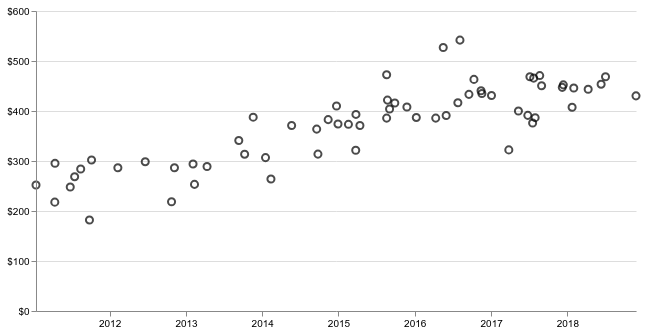

In [16]:
chart = alt.Chart(pwest).mark_point(size=50, color="black").encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", grid=False),
    ),
    y=alt.Y(
        "price_per_square_foot:Q",
        axis=alt.Axis(title="", format="$s"),
        scale=alt.Scale(domain=[0, 600])
    ),
    tooltip=["unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/price-per-sqft-by-date.svg')

chart

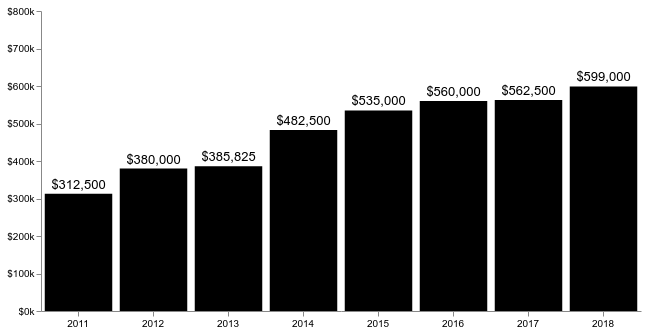

In [32]:
bars = alt.Chart(pwest).mark_bar(color="black").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750000]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price):Q', format="$,.0f")
)

chart = (bars + text).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/price-by-year.svg')

chart

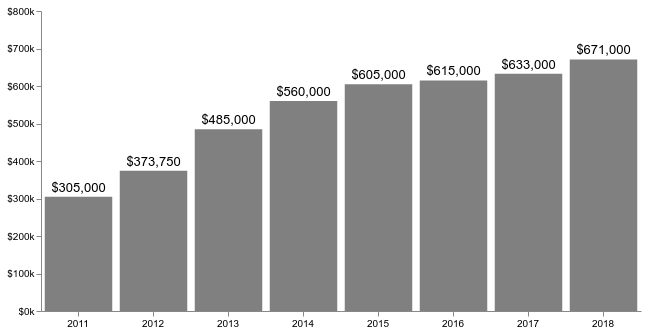

In [31]:
bars = alt.Chart(df).mark_bar(color="gray").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750000]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price):Q', format="$,.0f")
)

chart = (bars + text).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/dtla-price-by-year.svg')

chart

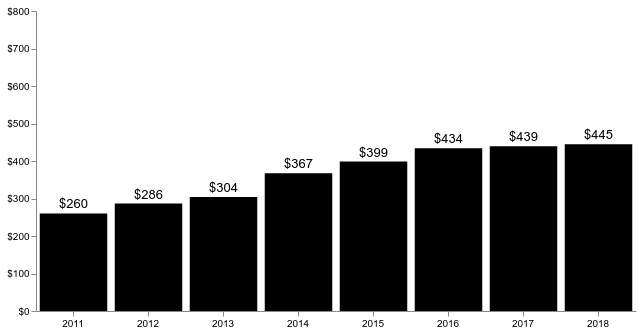

In [19]:
bars = alt.Chart(pwest).mark_bar(color="black").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price_per_square_foot):Q', format="$,.0f")
)

chart = (bars + text).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/price-per-sqft-by-year.svg')

chart

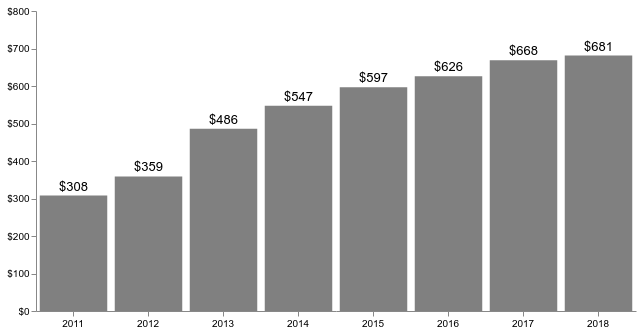

In [20]:
bars = alt.Chart(df).mark_bar(color="gray").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price_per_square_foot):Q', format="$,.0f")
)

chart = (bars + text).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/dtla-price-per-sqft-by-year.svg')

chart

## Bunker Hill

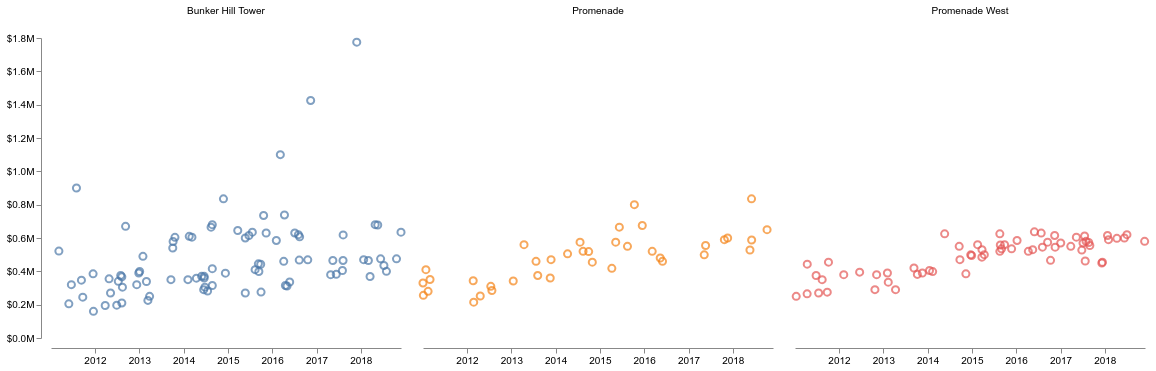

In [40]:
chart = alt.Chart(bunker_hill).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color=alt.Color("building_name:N", legend=None),
    column=alt.Column("building_name", title=""),
    tooltip=["building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=350).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/bunker-hill-price-by-date.svg')

chart

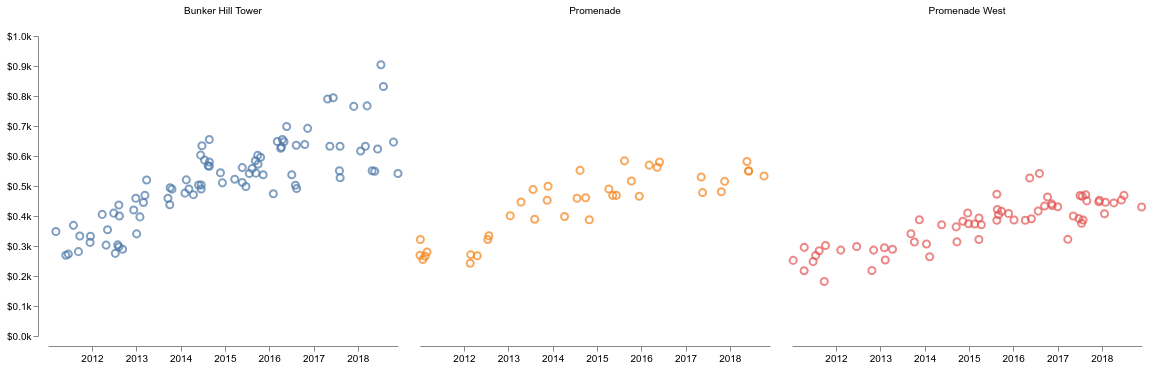

In [39]:
chart = alt.Chart(bunker_hill).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", grid=False),
    ),
    y=alt.Y(
        "price_per_square_foot:Q",
        axis=alt.Axis(title="", format="$s", grid=False)
    ),
    color=alt.Color("building_name:N", legend=None, title=""),
    column=alt.Column("building_name", title=""),
    tooltip=["building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=350).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/bunker-hill-price-per-sqft-by-date.svg')

chart

## Region

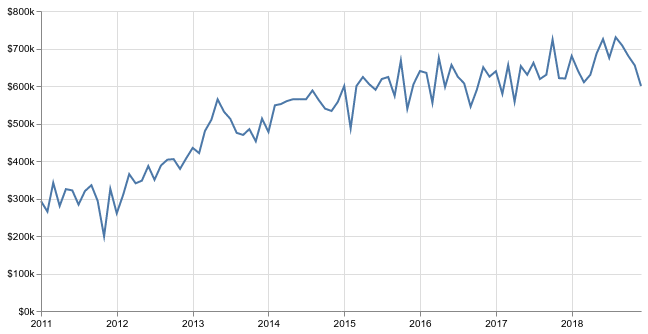

In [23]:
chart = alt.Chart(df).mark_line().encode(
    x=alt.X(
        "date:T",
        timeUnit="yearmonth",
        axis=alt.Axis(title="", labelAngle=0, format="%Y"),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s"),
    ),
).properties(width=600).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/price-by-year.svg')

chart

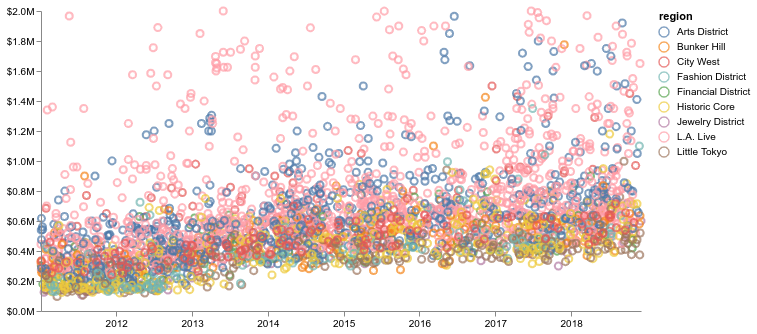

In [24]:
chart = alt.Chart(df).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color="region",
    #column=alt.Column("region", sort=alt.SortField(field="price", op="median", order="descending")),
    tooltip=["region", "building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).transform_filter(
    alt.datum.price <= 2000000
).properties(width=600).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/price-by-date.svg')

chart

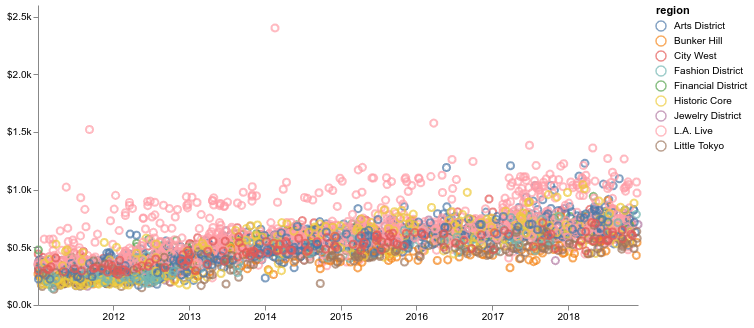

In [25]:
chart = alt.Chart(df).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price_per_square_foot:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color="region",
    tooltip=["region", "building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/price-by-date.svg')

chart

## Last 12 months

In [26]:
one_year_ago = datetime.now() - timedelta(days=365)

In [27]:
last_year = df[df.date > one_year_ago]

In [28]:
last_year.groupby(["region"]).agg({
    "unit": "count",
    "price": "median",
    "price_per_square_foot": "median",
    "square_feet": "median",
}).sort_values("price_per_square_foot", ascending=False)

,price,square_feet,unit,price_per_square_foot
region,,,,
Fashion District,570000.0,820.0,6,766.590126
Financial District,616250.0,880.0,10,726.773227
Jewelry District,525000.0,750.0,13,715.384615
L.A. Live,735000.0,1120.0,165,709.677419
Arts District,792000.0,1186.0,78,704.566153
Historic Core,525000.0,801.0,41,681.250000
City West,567500.0,975.0,28,643.158348
Little Tokyo,467500.0,876.5,36,556.623932
Bunker Hill,584000.0,1120.5,22,549.568246


In [29]:
last_year.groupby(["building_name", "region"]).agg({
    "unit": "count",
    "price": "median",
    "price_per_square_foot": "median",
    "square_feet": "median",
}).sort_values("price_per_square_foot", ascending=False)

,,price,square_feet,unit,price_per_square_foot
building_name,region,,,,
Metropolis Tower II,L.A. Live,1162000.0,918.0,3,1265.795207
Metropolis Tower I,L.A. Live,803000.0,783.0,7,1115.660184
Ritz Carlton,L.A. Live,1757500.0,1700.0,16,1054.209645
Ten50,L.A. Live,1099000.0,1144.0,17,986.842105
Biscuit Company Lofts,Arts District,850000.0,1052.0,11,851.851852
The Rowan,Historic Core,650000.0,720.0,11,847.222222
Gallery Lofts,Arts District,736000.0,866.0,3,837.182448
Barker Block Warehouse,Arts District,787500.0,991.0,4,794.419064
Santee Village: Cornell,Fashion District,540000.0,700.0,2,770.769231


## Largest units

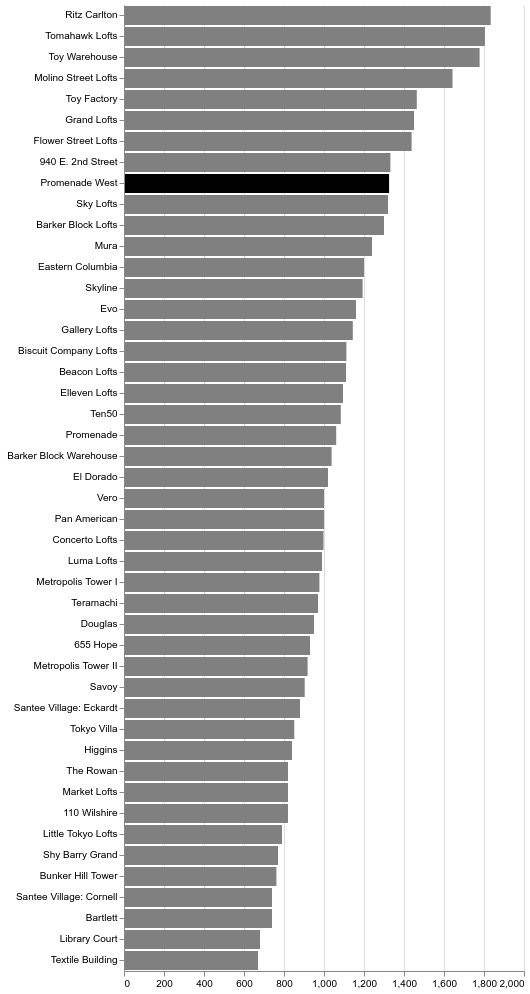

In [30]:
chart = alt.Chart(df).mark_bar().encode(
    x=alt.X(
        "median(square_feet):Q",
        axis=alt.Axis(title="")
    ),
    y=alt.Y(
        "building_name:N",
        axis=alt.Axis(title=""),
        sort=alt.SortField(field="square_feet", op="median", order="descending")
    ),
    color=alt.condition(
        alt.datum.building_name == 'Promenade West',
        alt.value("black"),
        alt.value("gray")
    )
).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/size-by-building.svg')

chart